In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import joblib
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/sample_submission.csv
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/Urun Ozellikleri.xlsx
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv


In [163]:
pd.set_option('display.max_columns', None)

__read csv file__

In [ ]:
train = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv")
test = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv")
test['LABEL'] = pd.Series([str('nan')] * len(test))
df_1 = pd.concat([train, test])

In [165]:
product_list = ["BU01", "BU02", "BU03", "BU04", "BU05", "BU06", "BU07", "BU08", "BU09", "BU10",
                "BU11", "BU12", "BU13", "BU14", "BU15", "BU16", "BU17", "BU18", "BU19", "BU20",
                "BU21", "BU22", "BU23", "BU24", "HU01", "HU02", "HU03", "HU04", "HU05", "HU06",
                "HU07", "HU10", "HU11", "HU12", "HU13", "HU14", "HU15", "HU16", "HU17", "HU18",
                "HU19"]


Convert all product features to binary

In [166]:
for col in product_list:
    df_1[col] = df_1[col].apply(lambda x: 1 if x > 0 else 0)

In [167]:
df_1.loc[df_1["ANAPARA"] == 0, "GETIRI"] = 0

In [168]:
df_1.loc[df_1['SORU_MEDENI_HAL_CVP'].isin(["Marriage Cancelled", "Marriage Annulled", "Other"]), 'SORU_MEDENI_HAL_CVP'] = "Married"


In [169]:
df = df_1.copy()

When the probabilities of occurrence of HAYAT and BES  products with each other were examined, no relationship was found between the dropped products and the targets.

In [170]:
df = df.drop(columns=["BU04", "BU05", "BU06", "BU07", "BU12", "BU14", "BU15", "BU21", "BU22", "BU24", "HU01", "HU02", "HU03", "HU13", "HU16"])


Convert "PP_CINSIYET" to binary

In [171]:
# cinsiyeti degistir
df['PP_CINSIYET'] = df['PP_CINSIYET'].replace(2, 0)

In [172]:
# Değiştirme için sözlük oluşturma
segment_mapping = {
    101: 'A',
    102: 'B',
    103: 'C',
    104: 'D',
    105: 'E',
    106: 'F'
}

# PP_MUSTERI_SEGMENTI sütununu belirtilen segmentlere göre değiştirme
df['PP_MUSTERI_SEGMENTI'] = df['PP_MUSTERI_SEGMENTI'].replace(segment_mapping)


In [173]:
# 36 orta yas sınırı
def get_age_group(age_in_months):
    if age_in_months < 18:
        return 'Çocuk'
    elif 18 <= age_in_months <= 24:
        return 'Genç'
    elif 24 < age_in_months <= 36:
        return 'Orta yaş'
    elif 36 < age_in_months <= 60:
        return 'Orta yaş üstü'
    else:
        return 'Yaşlı'

# PP_YAS değişkenine göre yaş segmentlerini oluşturma
df['AGE_GROUP'] = round(df['PP_YAS'] / 12)
  # Ay cinsinden yaşı yıla çevirme
df['AGE_GROUP'] = df['AGE_GROUP'].apply(get_age_group)


In [174]:
cat_cols = ["PP_CINSIYET", "PP_MESLEK", "PP_MUSTERI_SEGMENTI", 
            "SORU_YATIRIM_KARAKTERI_CVP", "SORU_MEDENI_HAL_CVP",
            "SORU_EGITIM_CVP", "AGE_GROUP"]

# Iterate through categorical columns
for col in cat_cols:
    # Check if the column is not "PP_CINSIYET" and has NaN values
    if col != "PP_CINSIYET" and df[col].isnull().sum() > 0:
        # Fill NaN values with "UNKNOWN"
        df[col].fillna("UNKNOWN", inplace=True)
        
        
        
        
        
df["medenihal_segment"] = ( df["SORU_MEDENI_HAL_CVP"].astype(str) + "_" + df["PP_MUSTERI_SEGMENTI"].astype(str) )

df["yatirimkarateri_segment"] = ( df["SORU_YATIRIM_KARAKTERI_CVP"].astype(str) + "_" + df["PP_MUSTERI_SEGMENTI"].astype(str) )

df["egitim_segment"] = ( df["SORU_EGITIM_CVP"].astype(str) + "_" + df["PP_MUSTERI_SEGMENTI"].astype(str) )

df["agegroup_segment"] =  ( df["AGE_GROUP"].astype(str) + "_" + df["PP_MUSTERI_SEGMENTI"].astype(str) )


/tmp/ipykernel_33/3773734052.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("UNKNOWN", inplace=True)


In [175]:
df.fillna(0, inplace=True)

In [176]:
df['KALAN_0'] = df['VADE_TUTAR_0'] - df['ODEME_TUTAR_0']
df['KALAN_1'] = df['VADE_TUTAR_1'] - df['ODEME_TUTAR_1']
df['KALAN_2'] = df['VADE_TUTAR_2'] - df['ODEME_TUTAR_2']
df['KALAN_3'] = df['VADE_TUTAR_3'] - df['ODEME_TUTAR_3']


columns_to_drop = ['VADE_TUTAR_4', 'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 
                   'VADE_TUTAR_6', 'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 
                   'VADE_TUTAR_8', 'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 
                   'VADE_TUTAR_10', 'ODEME_TUTAR_10', 'VADE_TUTAR_11','ODEME_TUTAR_11',
                   'VADE_TUTAR_0', 'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 
                   'VADE_TUTAR_2', 'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3']

df.drop(columns=columns_to_drop, inplace=True)


In [177]:
 df = df[["MUSTERI_ID",'LABEL', 'FLAG', 'PP_CINSIYET', 'PP_MUSTERI_SEGMENTI', 
        'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET', 'HAYAT_AYRILMA_TALEP_ADET', 
        'BILGI_TALEP_ADET',  'KALAN_0', 'KALAN_1', 'KALAN_2', 'KALAN_3','SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 
         'SON_CEYREK_KATKI_MIKTARI', 'SON_CEYREK_KATKI_ADET', 
        'SON_SENE_KATKI_MIKTARI', 'SON_SENE_KATKI_ADET', 'ANAPARA', 'GETIRI', 'AKTIF_ILK_POLICE_RG',
        'BU01', 'BU02', 'BU03', 'BU08', 'BU09', 'BU10', 'BU11', 'BU13', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 
         'BU23', 'HU04', 'HU05', 'HU06', 'HU07', 'HU10', 'HU11', 'HU12', 'HU14', 'HU15', 'HU17', 'HU18', 'HU19',
        'AGE_GROUP', "yatirimkarateri_segment", "medenihal_segment", "SORU_MEDENI_HAL_CVP", "egitim_segment", "SORU_EGITIM_CVP"
        ]]

In [178]:
# Etiketlerin sırasıyla indeks numaralarını belirleme
label_mapping = {'HU06': 0, 'HU07': 1, 'HU11': 2, 'HU12': 3, 'HU14': 4, 'HU15': 5, 'HU19': 6, 'UA': 7}

# Train veri setinde LABEL sütununu yeniden kodlama
df['LABEL'] = df['LABEL'].map(label_mapping)

kategorik değişkenlere one hot encoding

In [179]:
df = pd.get_dummies(df, columns=['PP_MUSTERI_SEGMENTI'], drop_first=True)
df = pd.get_dummies(df, columns=['AGE_GROUP'], drop_first=True)
df = pd.get_dummies(df, columns=["yatirimkarateri_segment", "medenihal_segment", "SORU_MEDENI_HAL_CVP"], drop_first=True)
df = pd.get_dummies(df, columns=["egitim_segment","SORU_EGITIM_CVP"], drop_first=True)


test train submission 

In [180]:
submission = df[(df["FLAG"] == "KASIM") | (df["FLAG"] == "ARALIK")].drop(columns= ["FLAG", "LABEL"])
train_df = df[~((df["FLAG"] == "KASIM") | (df["FLAG"] == "ARALIK"))].drop(columns= ["MUSTERI_ID", "FLAG"])


In [181]:
train_df

,LABEL,PP_CINSIYET,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,KALAN_0,KALAN_1,KALAN_2,KALAN_3,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,AKTIF_ILK_POLICE_RG,BU01,BU02,BU03,BU08,BU09,BU10,BU11,BU13,BU16,BU17,BU18,BU19,BU20,BU23,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU14,HU15,HU17,HU18,HU19,PP_MUSTERI_SEGMENTI_B,PP_MUSTERI_SEGMENTI_C,PP_MUSTERI_SEGMENTI_D,PP_MUSTERI_SEGMENTI_E,PP_MUSTERI_SEGMENTI_F,AGE_GROUP_Orta yaş,AGE_GROUP_Orta yaş üstü,AGE_GROUP_Yaşlı,AGE_GROUP_Çocuk,yatirimkarateri_segment_Bilge_B,yatirimkarateri_segment_Bilge_C,yatirimkarateri_segment_Bilge_D,yatirimkarateri_segment_Bilge_E,yatirimkarateri_segment_Bilge_F,yatirimkarateri_segment_Cesur_A,yatirimkarateri_segment_Cesur_B,yatirimkarateri_segment_Cesur_C,yatirimkarateri_segment_Cesur_D,yatirimkarateri_segment_Cesur_E,yatirimkarateri_segment_Cesur_F,yatirimkarateri_segment_Dengeli_A,yatirimkarateri_segment_Dengeli_B,yatirimkarateri_segment_Dengeli_C,yatirimkarateri_segment_Dengeli_D,yatirimkarateri_segment_Dengeli_E,yatirimkarateri_segment_Dengeli_F,yatirimkarateri_segment_Temkinli_A,yatirimkarateri_segment_Temkinli_B,yatirimkarateri_segment_Temkinli_C,yatirimkarateri_segment_Temkinli_D,yatirimkarateri_segment_Temkinli_E,yatirimkarateri_segment_Temkinli_F,yatirimkarateri_segment_UNKNOWN_A,yatirimkarateri_segment_UNKNOWN_B,yatirimkarateri_segment_UNKNOWN_C,yatirimkarateri_segment_UNKNOWN_D,yatirimkarateri_segment_UNKNOWN_E,yatirimkarateri_segment_UNKNOWN_F,yatirimkarateri_segment_Yetkin_A,yatirimkarateri_segment_Yetkin_B,yatirimkarateri_segment_Yetkin_C,yatirimkarateri_segment_Yetkin_D,yatirimkarateri_segment_Yetkin_E,yatirimkarateri_segment_Yetkin_F,medenihal_segment_Divorced_B,medenihal_segment_Divorced_C,medenihal_segment_Divorced_D,medenihal_segment_Divorced_E,medenihal_segment_Divorced_F,medenihal_segment_Married_A,medenihal_segment_Married_B,medenihal_segment_Married_C,medenihal_segment_Married_D,medenihal_segment_Married_E,medenihal_segment_Married_F,medenihal_segment_Single_A,medenihal_segment_Single_B,medenihal_segment_Single_C,medenihal_segment_Single_D,medenihal_segment_Single_E,medenihal_segment_Single_F,medenihal_segment_UNKNOWN_B,medenihal_segment_UNKNOWN_C,medenihal_segment_UNKNOWN_D,medenihal_segment_UNKNOWN_E,medenihal_segment_UNKNOWN_F,medenihal_segment_Widowed_A,medenihal_segment_Widowed_B,medenihal_segment_Widowed_C,medenihal_segment_Widowed_D,medenihal_segment_Widowed_E,medenihal_segment_Widowed_F,SORU_MEDENI_HAL_CVP_Married,SORU_MEDENI_HAL_CVP_Single,SORU_MEDENI_HAL_CVP_UNKNOWN,SORU_MEDENI_HAL_CVP_Widowed,egitim_segment_(Diğer)_B,egitim_segment_(Diğer)_C,egitim_segment_(Diğer)_D,egitim_segment_(Diğer)_E,egitim_segment_(Diğer)_F,egitim_segment_Doktora_A,egitim_segment_Doktora_B,egitim_segment_Doktora_C,egitim_segment_Doktora_D,egitim_segment_Doktora_E,egitim_segment_Doktora_F,egitim_segment_Lisans_A,egitim_segment_Lisans_B,egitim_segment_Lisans_C,egitim_segment_Lisans_D,egitim_segment_Lisans_E,egitim_segment_Lisans_F,egitim_segment_Lise_A,egitim_segment_Lise_B,egitim_segment_Lise_C,egitim_segment_Lise_D,egitim_segment_Lise_E,egitim_segment_Lise_F,egitim_segment_UNKNOWN_A,egitim_segment_UNKNOWN_B,egitim_segment_UNKNOWN_C,egitim_segment_UNKNOWN_D,egitim_segment_UNKNOWN_E,egitim_segment_UNKNOWN_F,egitim_segment_Yüksek Lisans_A,egitim_segment_Yüksek Lisans_B,egitim_segment_Yüksek Lisans_C,egitim_segment_Yüksek Lisans_D,egitim_segment_Yüksek Lisans_E,egitim_segment_Yüksek Lisans_F,egitim_segment_Önlisans_A,egitim_segment_Önlisans_B,egitim_segment_Önlisans_C,egitim_segment_Önlisans_D,egitim_segment_Önlisans_E,egitim_segment_Önlisans_F,egitim_segment_İlköğretim_A,egitim_segment_İlköğretim_B,egitim_segment_İlköğretim_C,egitim_segment_İlköğretim_D,egitim_segment_İlköğretim_E,egitim_segment_İlköğretim_F,SORU_EGITIM_CVP_Doktora,SORU_EGITIM_CVP_Lisans,SORU_EGITIM_CVP_Lise,SORU_EGITIM_CVP_UNKNOWN,SORU_EGITIM_CVP_Yükse

sample size

In [182]:
import pandas as pd
from sklearn.utils import resample

# Hedeflenen örnek sayısı HU14 sınıfının örnek sayısına eşit olacak
target_samples = len(train_df[train_df['LABEL'] == 4])

# UA sınıfının örnek sayısını HU14 sınıfının örnek sayısına indirin
ua_df = train_df[train_df['LABEL'] == 7].sample(n=320000, random_state=1)

# Diğer sınıfların örnek sayılarını belirtilen hedef sayıya ulaşana kadar artırın
other_dfs = []
for cls in [0, 1, 2, 3, 5, 6]:
    class_df = train_df[train_df['LABEL'] == cls]
    oversampled_df = resample(class_df, n_samples=target_samples, replace=True, random_state=42)
    other_dfs.append(oversampled_df)

# HU14 sınıfının örneklerini alın (zaten hedeflenen sayıya eşit olduğundan)
hu14_df = train_df[train_df['LABEL'] == 4]
#hu14_df = hu14_df.sample(n=69500, replace=True)


# Tüm sınıfların veri çerçevelerini birleştirin
balanced_train_df = pd.concat([ua_df] + other_dfs + [hu14_df])

# Sonuçları karıştırın (isteğe bağlı)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Dengelenmiş eğitim veri setini kullanın
print(balanced_train_df['LABEL'].value_counts())



LABEL
7.0    320000
2.0     10754
3.0     10754
0.0     10754
5.0     10754
4.0     10754
6.0     10754
1.0     10754
Name: count, dtype: int64


train test bagımlı bagımsız değişkenler

In [183]:
# encoded_train için X ve y ayırma
X_train = balanced_train_df.drop("LABEL", axis=1)
y_train = balanced_train_df["LABEL"]

In [184]:
# XGBoost modelini oluşturma
xgboost_model = XGBClassifier(n_estimators=80, learning_rate=0.1,
                              max_depth=6, colsample_bytree=0.7, 
                              random_state=42, use_label_encoder=False)

# Modeli eğitme
model = xgboost_model.fit(X_train, y_train)

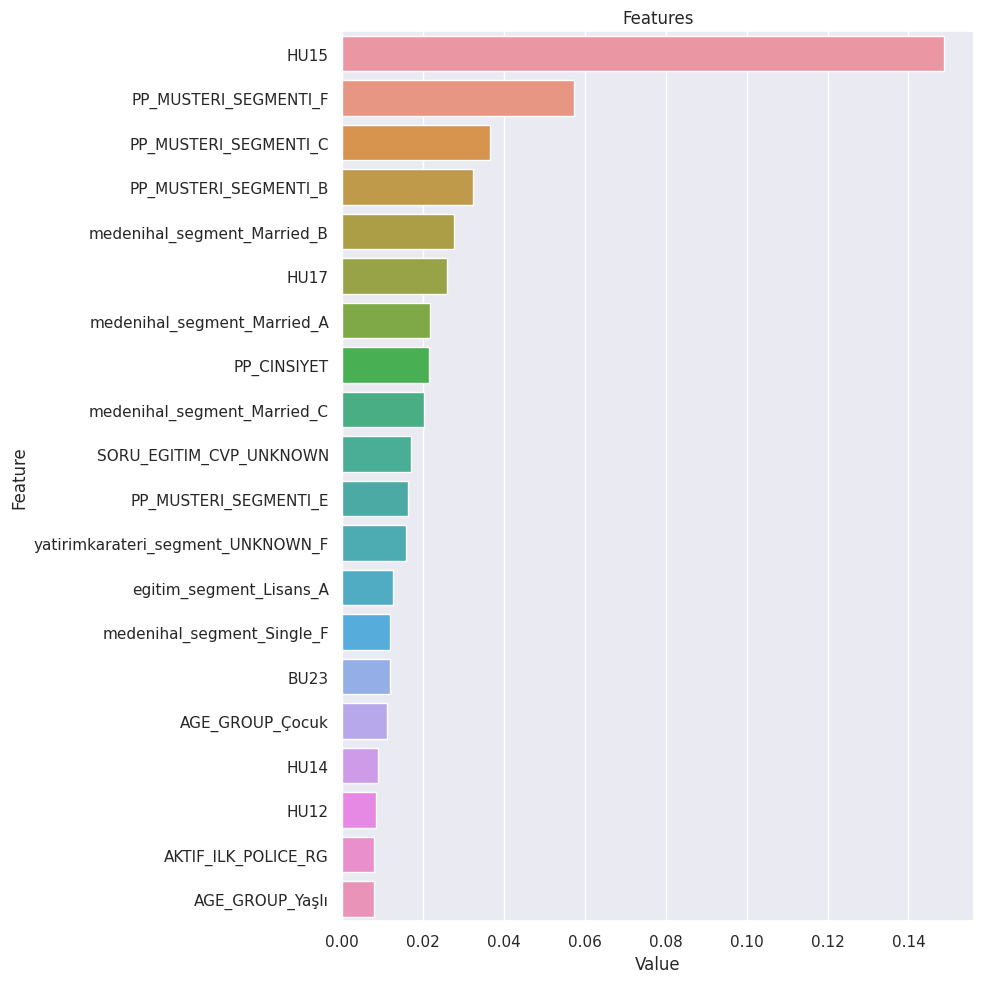

In [185]:
def plot_importance(model, features, num=20, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
import matplotlib.pyplot as plt
import seaborn as sns
plot_importance(model, X_train)

In [186]:
gonder = submission.drop("MUSTERI_ID", axis=1)

In [187]:
submission

,MUSTERI_ID,PP_CINSIYET,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,KALAN_0,KALAN_1,KALAN_2,KALAN_3,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,AKTIF_ILK_POLICE_RG,BU01,BU02,BU03,BU08,BU09,BU10,BU11,BU13,BU16,BU17,BU18,BU19,BU20,BU23,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU14,HU15,HU17,HU18,HU19,PP_MUSTERI_SEGMENTI_B,PP_MUSTERI_SEGMENTI_C,PP_MUSTERI_SEGMENTI_D,PP_MUSTERI_SEGMENTI_E,PP_MUSTERI_SEGMENTI_F,AGE_GROUP_Orta yaş,AGE_GROUP_Orta yaş üstü,AGE_GROUP_Yaşlı,AGE_GROUP_Çocuk,yatirimkarateri_segment_Bilge_B,yatirimkarateri_segment_Bilge_C,yatirimkarateri_segment_Bilge_D,yatirimkarateri_segment_Bilge_E,yatirimkarateri_segment_Bilge_F,yatirimkarateri_segment_Cesur_A,yatirimkarateri_segment_Cesur_B,yatirimkarateri_segment_Cesur_C,yatirimkarateri_segment_Cesur_D,yatirimkarateri_segment_Cesur_E,yatirimkarateri_segment_Cesur_F,yatirimkarateri_segment_Dengeli_A,yatirimkarateri_segment_Dengeli_B,yatirimkarateri_segment_Dengeli_C,yatirimkarateri_segment_Dengeli_D,yatirimkarateri_segment_Dengeli_E,yatirimkarateri_segment_Dengeli_F,yatirimkarateri_segment_Temkinli_A,yatirimkarateri_segment_Temkinli_B,yatirimkarateri_segment_Temkinli_C,yatirimkarateri_segment_Temkinli_D,yatirimkarateri_segment_Temkinli_E,yatirimkarateri_segment_Temkinli_F,yatirimkarateri_segment_UNKNOWN_A,yatirimkarateri_segment_UNKNOWN_B,yatirimkarateri_segment_UNKNOWN_C,yatirimkarateri_segment_UNKNOWN_D,yatirimkarateri_segment_UNKNOWN_E,yatirimkarateri_segment_UNKNOWN_F,yatirimkarateri_segment_Yetkin_A,yatirimkarateri_segment_Yetkin_B,yatirimkarateri_segment_Yetkin_C,yatirimkarateri_segment_Yetkin_D,yatirimkarateri_segment_Yetkin_E,yatirimkarateri_segment_Yetkin_F,medenihal_segment_Divorced_B,medenihal_segment_Divorced_C,medenihal_segment_Divorced_D,medenihal_segment_Divorced_E,medenihal_segment_Divorced_F,medenihal_segment_Married_A,medenihal_segment_Married_B,medenihal_segment_Married_C,medenihal_segment_Married_D,medenihal_segment_Married_E,medenihal_segment_Married_F,medenihal_segment_Single_A,medenihal_segment_Single_B,medenihal_segment_Single_C,medenihal_segment_Single_D,medenihal_segment_Single_E,medenihal_segment_Single_F,medenihal_segment_UNKNOWN_B,medenihal_segment_UNKNOWN_C,medenihal_segment_UNKNOWN_D,medenihal_segment_UNKNOWN_E,medenihal_segment_UNKNOWN_F,medenihal_segment_Widowed_A,medenihal_segment_Widowed_B,medenihal_segment_Widowed_C,medenihal_segment_Widowed_D,medenihal_segment_Widowed_E,medenihal_segment_Widowed_F,SORU_MEDENI_HAL_CVP_Married,SORU_MEDENI_HAL_CVP_Single,SORU_MEDENI_HAL_CVP_UNKNOWN,SORU_MEDENI_HAL_CVP_Widowed,egitim_segment_(Diğer)_B,egitim_segment_(Diğer)_C,egitim_segment_(Diğer)_D,egitim_segment_(Diğer)_E,egitim_segment_(Diğer)_F,egitim_segment_Doktora_A,egitim_segment_Doktora_B,egitim_segment_Doktora_C,egitim_segment_Doktora_D,egitim_segment_Doktora_E,egitim_segment_Doktora_F,egitim_segment_Lisans_A,egitim_segment_Lisans_B,egitim_segment_Lisans_C,egitim_segment_Lisans_D,egitim_segment_Lisans_E,egitim_segment_Lisans_F,egitim_segment_Lise_A,egitim_segment_Lise_B,egitim_segment_Lise_C,egitim_segment_Lise_D,egitim_segment_Lise_E,egitim_segment_Lise_F,egitim_segment_UNKNOWN_A,egitim_segment_UNKNOWN_B,egitim_segment_UNKNOWN_C,egitim_segment_UNKNOWN_D,egitim_segment_UNKNOWN_E,egitim_segment_UNKNOWN_F,egitim_segment_Yüksek Lisans_A,egitim_segment_Yüksek Lisans_B,egitim_segment_Yüksek Lisans_C,egitim_segment_Yüksek Lisans_D,egitim_segment_Yüksek Lisans_E,egitim_segment_Yüksek Lisans_F,egitim_segment_Önlisans_A,egitim_segment_Önlisans_B,egitim_segment_Önlisans_C,egitim_segment_Önlisans_D,egitim_segment_Önlisans_E,egitim_segment_Önlisans_F,egitim_segment_İlköğretim_A,egitim_segment_İlköğretim_B,egitim_segment_İlköğretim_C,egitim_segment_İlköğretim_D,egitim_segment_İlköğretim_E,egitim_segment_İlköğretim_F,SORU_EGITIM_CVP_Doktora,SORU_EGITIM_CVP_Lisans,SORU_EGITIM_CVP_Lise,SORU_EGITIM_CVP_UNKNOWN,SORU_EGITIM_CVP_

In [188]:
submission["LABEL"] = model.predict(gonder)

In [189]:
submission

,MUSTERI_ID,PP_CINSIYET,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,KALAN_0,KALAN_1,KALAN_2,KALAN_3,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,AKTIF_ILK_POLICE_RG,BU01,BU02,BU03,BU08,BU09,BU10,BU11,BU13,BU16,BU17,BU18,BU19,BU20,BU23,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU14,HU15,HU17,HU18,HU19,PP_MUSTERI_SEGMENTI_B,PP_MUSTERI_SEGMENTI_C,PP_MUSTERI_SEGMENTI_D,PP_MUSTERI_SEGMENTI_E,PP_MUSTERI_SEGMENTI_F,AGE_GROUP_Orta yaş,AGE_GROUP_Orta yaş üstü,AGE_GROUP_Yaşlı,AGE_GROUP_Çocuk,yatirimkarateri_segment_Bilge_B,yatirimkarateri_segment_Bilge_C,yatirimkarateri_segment_Bilge_D,yatirimkarateri_segment_Bilge_E,yatirimkarateri_segment_Bilge_F,yatirimkarateri_segment_Cesur_A,yatirimkarateri_segment_Cesur_B,yatirimkarateri_segment_Cesur_C,yatirimkarateri_segment_Cesur_D,yatirimkarateri_segment_Cesur_E,yatirimkarateri_segment_Cesur_F,yatirimkarateri_segment_Dengeli_A,yatirimkarateri_segment_Dengeli_B,yatirimkarateri_segment_Dengeli_C,yatirimkarateri_segment_Dengeli_D,yatirimkarateri_segment_Dengeli_E,yatirimkarateri_segment_Dengeli_F,yatirimkarateri_segment_Temkinli_A,yatirimkarateri_segment_Temkinli_B,yatirimkarateri_segment_Temkinli_C,yatirimkarateri_segment_Temkinli_D,yatirimkarateri_segment_Temkinli_E,yatirimkarateri_segment_Temkinli_F,yatirimkarateri_segment_UNKNOWN_A,yatirimkarateri_segment_UNKNOWN_B,yatirimkarateri_segment_UNKNOWN_C,yatirimkarateri_segment_UNKNOWN_D,yatirimkarateri_segment_UNKNOWN_E,yatirimkarateri_segment_UNKNOWN_F,yatirimkarateri_segment_Yetkin_A,yatirimkarateri_segment_Yetkin_B,yatirimkarateri_segment_Yetkin_C,yatirimkarateri_segment_Yetkin_D,yatirimkarateri_segment_Yetkin_E,yatirimkarateri_segment_Yetkin_F,medenihal_segment_Divorced_B,medenihal_segment_Divorced_C,medenihal_segment_Divorced_D,medenihal_segment_Divorced_E,medenihal_segment_Divorced_F,medenihal_segment_Married_A,medenihal_segment_Married_B,medenihal_segment_Married_C,medenihal_segment_Married_D,medenihal_segment_Married_E,medenihal_segment_Married_F,medenihal_segment_Single_A,medenihal_segment_Single_B,medenihal_segment_Single_C,medenihal_segment_Single_D,medenihal_segment_Single_E,medenihal_segment_Single_F,medenihal_segment_UNKNOWN_B,medenihal_segment_UNKNOWN_C,medenihal_segment_UNKNOWN_D,medenihal_segment_UNKNOWN_E,medenihal_segment_UNKNOWN_F,medenihal_segment_Widowed_A,medenihal_segment_Widowed_B,medenihal_segment_Widowed_C,medenihal_segment_Widowed_D,medenihal_segment_Widowed_E,medenihal_segment_Widowed_F,SORU_MEDENI_HAL_CVP_Married,SORU_MEDENI_HAL_CVP_Single,SORU_MEDENI_HAL_CVP_UNKNOWN,SORU_MEDENI_HAL_CVP_Widowed,egitim_segment_(Diğer)_B,egitim_segment_(Diğer)_C,egitim_segment_(Diğer)_D,egitim_segment_(Diğer)_E,egitim_segment_(Diğer)_F,egitim_segment_Doktora_A,egitim_segment_Doktora_B,egitim_segment_Doktora_C,egitim_segment_Doktora_D,egitim_segment_Doktora_E,egitim_segment_Doktora_F,egitim_segment_Lisans_A,egitim_segment_Lisans_B,egitim_segment_Lisans_C,egitim_segment_Lisans_D,egitim_segment_Lisans_E,egitim_segment_Lisans_F,egitim_segment_Lise_A,egitim_segment_Lise_B,egitim_segment_Lise_C,egitim_segment_Lise_D,egitim_segment_Lise_E,egitim_segment_Lise_F,egitim_segment_UNKNOWN_A,egitim_segment_UNKNOWN_B,egitim_segment_UNKNOWN_C,egitim_segment_UNKNOWN_D,egitim_segment_UNKNOWN_E,egitim_segment_UNKNOWN_F,egitim_segment_Yüksek Lisans_A,egitim_segment_Yüksek Lisans_B,egitim_segment_Yüksek Lisans_C,egitim_segment_Yüksek Lisans_D,egitim_segment_Yüksek Lisans_E,egitim_segment_Yüksek Lisans_F,egitim_segment_Önlisans_A,egitim_segment_Önlisans_B,egitim_segment_Önlisans_C,egitim_segment_Önlisans_D,egitim_segment_Önlisans_E,egitim_segment_Önlisans_F,egitim_segment_İlköğretim_A,egitim_segment_İlköğretim_B,egitim_segment_İlköğretim_C,egitim_segment_İlköğretim_D,egitim_segment_İlköğretim_E,egitim_segment_İlköğretim_F,SORU_EGITIM_CVP_Doktora,SORU_EGITIM_CVP_Lisans,SORU_EGITIM_CVP_Lise,SORU_EGITIM_CVP_UNKNOWN,SORU_EGITIM_CVP_

In [190]:
submission["LABEL"].value_counts()

LABEL
7    191817
1      1274
4      1007
6       460
2       438
3       413
0       166
5        56
Name: count, dtype: int64

In [191]:
submission["LABEL"].value_counts()

LABEL
7    191817
1      1274
4      1007
6       460
2       438
3       413
0       166
5        56
Name: count, dtype: int64

In [192]:
label_mapping = {'HU06': 0, 'HU07': 1, 'HU11': 2, 'HU12': 3, 'HU14': 4, 'HU15': 5, 'HU19': 6, 'UA': 7}


In [193]:
submission["LABEL"] = submission["LABEL"].map({v: k for k, v in label_mapping.items()})


In [194]:
submission = submission[["MUSTERI_ID", "LABEL"]].to_csv("submission.csv", index=False)